In [248]:
import numpy as np

In [249]:
import pandas as pd

In [250]:
import seaborn as sns

In [251]:
import os

In [252]:
input_path = "../../input"

In [253]:
train_df = pd.read_csv(os.path.join(input_path, 'train/train.csv'))

In [254]:
test_df = pd.read_csv(os.path.join(input_path, 'test/test.csv'))

### Looking on label balance in dataset

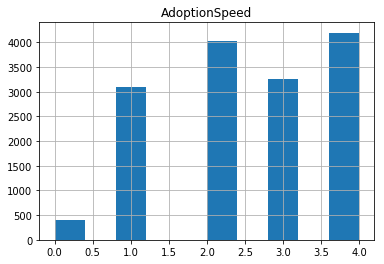

In [255]:
adoption_speed_hist = train_df.hist('AdoptionSpeed')

In [256]:
train_df['Name'] = train_df['Name'].fillna('No Name')
test_df['Name'] = test_df['Name'].fillna('No Name')

In [257]:
train_df['No_name'] = 0
train_df.loc[(train_df['Name'] == 'No Name') | 
             (train_df['Name'] == 'No Name Yet'), 'No_name'] = 1
test_df['No_name'] = 0
test_df.loc[(test_df['Name'] == 'No Name')| 
             (test_df['Name'] == 'No Name Yet'), 'No_name'] = 1

In [258]:
train_df['Bad_name'] = 0
train_df.loc[train_df['Name'].apply(lambda x: len(str(x))) < 3, 'Bad_name'] = 1

In [259]:
test_df['Bad_name'] = 0
test_df.loc[test_df['Name'].apply(lambda x: len(str(x))) < 3, 'Bad_name'] = 1

### Drop not-using features

In [260]:
# drop text features and hash id`s
drop_list = ['PetID', 
             'RescuerID', 
             'Description']

In [261]:
pet_id_test = test_df['PetID']

In [262]:
y = train_df['AdoptionSpeed']

In [263]:
X = train_df.drop(drop_list, axis=1)

In [264]:
# X = X.drop('AdoptionSpeed', axis=1)

In [265]:
X_test = test_df.drop(drop_list, axis=1)

### Select cat features

In [266]:
def get_column_indeces_from_names(df,name_list):
    indeces = []
    for name in name_list:
        indeces.append(df.columns.get_loc(name))
    return indeces

In [267]:
cat_feature_names = [
    'Type',
    'Breed1',
    'Breed2',
    'Gender',
    'Color1',
    'Color2',
    'Color3',
    'Vaccinated',
    'Dewormed',
    'Sterilized',
    'Health',
    'State',
    'No_name',
    'Bad_name'
]

### Create cd and pool

In [268]:
from catboost.utils import create_cd

In [269]:
label_index = X.columns.get_loc('AdoptionSpeed')

In [270]:
def make_feature_names_dict(df, label_name):
    columns = list(df.columns)
    columns.remove(label_name)
    column_indices = get_column_indeces_from_names(df, columns)
        
    return dict(zip(column_indices, columns))

In [271]:
X = X.drop(['Name', 'AdoptionSpeed'], axis=1)

In [272]:
X.head()

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,...,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,PhotoAmt,No_name,Bad_name
0,2,3,299,0,1,1,7,0,1,1,...,2,2,1,1,100,41326,0,1.0,0,0
1,2,1,265,0,1,1,2,0,2,2,...,3,3,1,1,0,41401,0,2.0,1,0
2,1,1,307,0,1,2,7,0,2,2,...,1,2,1,1,0,41326,0,7.0,0,0
3,1,4,307,0,2,1,2,0,2,1,...,1,2,1,1,150,41401,0,8.0,0,0
4,1,1,307,0,1,1,0,0,2,1,...,2,2,1,1,0,41326,0,3.0,0,0


In [273]:
cat_features = get_column_indeces_from_names(X, cat_feature_names)

In [274]:
print(cat_features)

[0, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 19, 20]


In [275]:
from catboost import CatBoostClassifier, Pool

In [276]:
from sklearn.model_selection import train_test_split

In [277]:
X_train, X_valid, y_train, y_valid = train_test_split(X,
                                                        y, 
                                                        train_size=0.8,
                                                        stratify=y
    )

/home/roman-baldaev/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [278]:
pool_train = Pool(data=X_train,
                 label=y_train,
                 cat_features=cat_features)

In [279]:
pool_valid = Pool(data=X_valid,
                 label=y_valid,
                 cat_features=cat_features)

In [280]:
(pool_train.shape, pool_valid.shape)

((11994, 21), (2999, 21))

In [281]:
clf = CatBoostClassifier(iterations=200,
                            loss_function = 'MultiClass',
                            depth=4,
                            leaf_estimation_iterations = 20,
                            use_best_model=True,
                            classes_count=5
    )

In [282]:
clf.fit(pool_train,
            logging_level='Verbose',
            eval_set=pool_valid
    )

0:	learn: -1.5966076	test: -1.5967380	best: -1.5967380 (0)	total: 345ms	remaining: 1m 8s
1:	learn: -1.5849510	test: -1.5851581	best: -1.5851581 (1)	total: 624ms	remaining: 1m 1s
2:	learn: -1.5734740	test: -1.5739338	best: -1.5739338 (2)	total: 1.01s	remaining: 1m 6s
3:	learn: -1.5632081	test: -1.5636967	best: -1.5636967 (3)	total: 1.39s	remaining: 1m 7s
4:	learn: -1.5532444	test: -1.5539497	best: -1.5539497 (4)	total: 1.77s	remaining: 1m 9s
5:	learn: -1.5445098	test: -1.5452699	best: -1.5452699 (5)	total: 2.15s	remaining: 1m 9s
6:	learn: -1.5354281	test: -1.5364638	best: -1.5364638 (6)	total: 2.52s	remaining: 1m 9s
7:	learn: -1.5280884	test: -1.5292894	best: -1.5292894 (7)	total: 2.89s	remaining: 1m 9s
8:	learn: -1.5210181	test: -1.5224233	best: -1.5224233 (8)	total: 3.25s	remaining: 1m 8s
9:	learn: -1.5143252	test: -1.5159139	best: -1.5159139 (9)	total: 3.64s	remaining: 1m 9s
10:	learn: -1.5083317	test: -1.5100414	best: -1.5100414 (10)	total: 4s	remaining: 1m 8s
11:	learn: -1.5020400	

91:	learn: -1.3761263	test: -1.3858464	best: -1.3858464 (91)	total: 37.8s	remaining: 44.4s
92:	learn: -1.3754405	test: -1.3853551	best: -1.3853551 (92)	total: 38.2s	remaining: 43.9s
93:	learn: -1.3749927	test: -1.3849619	best: -1.3849619 (93)	total: 38.5s	remaining: 43.5s
94:	learn: -1.3748202	test: -1.3848474	best: -1.3848474 (94)	total: 38.9s	remaining: 42.9s
95:	learn: -1.3745198	test: -1.3845647	best: -1.3845647 (95)	total: 39.2s	remaining: 42.5s
96:	learn: -1.3740092	test: -1.3840558	best: -1.3840558 (96)	total: 39.6s	remaining: 42s
97:	learn: -1.3735024	test: -1.3835551	best: -1.3835551 (97)	total: 39.9s	remaining: 41.6s
98:	learn: -1.3733204	test: -1.3833938	best: -1.3833938 (98)	total: 40.3s	remaining: 41.1s
99:	learn: -1.3730451	test: -1.3831989	best: -1.3831989 (99)	total: 40.6s	remaining: 40.6s
100:	learn: -1.3727045	test: -1.3829158	best: -1.3829158 (100)	total: 40.9s	remaining: 40.1s
101:	learn: -1.3724587	test: -1.3825913	best: -1.3825913 (101)	total: 41.3s	remaining: 39.

180:	learn: -1.3556199	test: -1.3686434	best: -1.3686434 (180)	total: 1m 14s	remaining: 7.83s
181:	learn: -1.3555967	test: -1.3686370	best: -1.3686370 (181)	total: 1m 14s	remaining: 7.41s
182:	learn: -1.3553495	test: -1.3683790	best: -1.3683790 (182)	total: 1m 15s	remaining: 7s
183:	learn: -1.3552264	test: -1.3683606	best: -1.3683606 (183)	total: 1m 15s	remaining: 6.58s
184:	learn: -1.3551746	test: -1.3682897	best: -1.3682897 (184)	total: 1m 16s	remaining: 6.16s
185:	learn: -1.3550128	test: -1.3681621	best: -1.3681621 (185)	total: 1m 16s	remaining: 5.75s
186:	learn: -1.3548090	test: -1.3680269	best: -1.3680269 (186)	total: 1m 16s	remaining: 5.33s
187:	learn: -1.3546516	test: -1.3678653	best: -1.3678653 (187)	total: 1m 17s	remaining: 4.92s
188:	learn: -1.3544799	test: -1.3676389	best: -1.3676389 (188)	total: 1m 17s	remaining: 4.5s
189:	learn: -1.3543571	test: -1.3675873	best: -1.3675873 (189)	total: 1m 17s	remaining: 4.09s
190:	learn: -1.3543083	test: -1.3675504	best: -1.3675504 (190)	t

In [283]:
X_test = X_test.drop(['Name'], axis=1)

In [284]:
pred_test = clf.predict(X_test)

In [285]:
pred = list(map(lambda x: int(x[0]), pred_test))

In [286]:
submit_df = pd.DataFrame(data={'PetID': pet_id_test, 'AdoptionSpeed': pred})

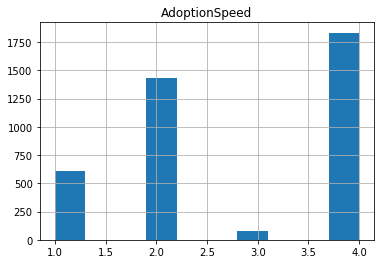

In [287]:
submit_target_hist = submit_df.hist('AdoptionSpeed')

In [246]:
submit_df.head()

,PetID,AdoptionSpeed
0,378fcc4fc,2
1,73c10e136,4
2,72000c4c5,4
3,e147a4b9f,4
4,43fbba852,4


In [247]:
submit_df.to_csv('submission.csv', index=False)